## NGram Exploration

This notebook analyzes ngram usage and ngram matching algorithms for ASAG.

In [80]:
import spacy
import sys
sys.path.append('../')
import libs.utils as utils
import libs.stats as stats
from importlib import reload
from nltk import ngrams
import numpy as np
nlp_en = spacy.load('en')

In [4]:
df2_en = utils.load_dataframe(language='en', version=2)

In [7]:
ma = df2_en.iloc[0]['Model Answer']
print('MA:', ma)
s1 = df2_en.iloc[1]['Student Answer']
print('SA:', s1)

MA:  To simulate the behaviour of portions of the desired software product. 
SA:  To simulate portions of the desired final product with a quick and easy program that does a small specific job.  It is a way to help see what the problem is and how you may solve it in the final project. 


In [94]:
def create_ngrams(nlp, sent):
    tokens = [t for t in nlp(sent)]
    
    # Grab lemmas, remove stopwords, remove punctuation and space
    lemmas = []
    for t in tokens:
        if t.is_stop or t.dep_ == 'punct' or t.pos_ == 'SPACE':
            continue
        if t.pos_ == 'PRON':
            lemmas.append(t.text.lower())
        else:
            if 'neg' in [x.dep_ for x in list(t.children)]:
                lemmas.append('neg_{}'.format(t))
            else:
                lemmas.append(t.lemma_)
                
    # bigrams
    n1 = list(ngrams(lemmas, 1))
    n2 = list(ngrams(lemmas, 2))
    n3 = list(ngrams(lemmas, 3))
    
    return { 'n1' : [n1, 1], 'n2' : [n2, 2], 'n3' : [n3, 3] }
    
def look_for_evidence(nlp, ma, sa):
    
    model_ngrams = create_ngrams(nlp, ma)
    student_ngrams = create_ngrams(nlp, sa)
    hits = {}
    all_matches = {}
    
    for key in model_ngrams.keys():
        model_ng = model_ngrams[key][0]
        student_ng = student_ngrams[key][0]
        
        hits[key] = { 'hits' : 0, 
                      'size' : len(model_ng), 
                      'ngram_size' : model_ngrams[key][1] }
        
        for g in model_ng:
            for sg in student_ng:
                if g == sg:
                    hits[key]['hits'] += 1
                if not g in all_matches:
                    all_matches[g] = 1
                else:
                    all_matches[g] += 1
                    
            
    return hits

def score_hits(hits):
    n = len(hits.keys())
    
    
    # Setup Weights
    w = []
    for k in hits.keys():
        size = hits[k]['size']
        w.append(size)
        
    w = np.array(w)
    w = np.sum(w / np.max(w))
    
    # Calculate scores for each ngram section
    x = []
    for key in hits.keys():
        power = hits[key]['ngram_size']
        hit_counts = hits[key]['hits']
        size = hits[key]['size']
        if size > 0:
            tmp = np.power(hit_counts / size, (1/power))
            x.append(tmp)
        else:
            x.append(0.0)
    
    score = np.sum(x) / np.sum(w)
    return np.min([1.0, score])

In [95]:
df2_en = utils.load_dataframe(language='en', version=2)
print(len(df2_en))

def evaluate_model(nlp, df):
    
    y_true_raw = df['Score']
    y_true = np.round(y_true_raw)
    y_pred = []
    y_pred_raw = []
    
    for index, row in df.iterrows():
        ma = row['Model Answer']
        sa = row['Student Answer']
        
        hits = look_for_evidence(nlp, ma, sa)
        hit_score = score_hits(hits)
        score = np.round(5 * hit_score)
        y_pred_raw.append(hit_score)
        y_pred.append(score)
        
    return { 
        'y_true_raw' : y_true_raw,
        'y_true' : y_true,
        'y_pred_raw' : y_pred_raw,
        'y_pred' : y_pred
    }

res_e1_1 = evaluate_model(nlp_en, df2_en)

2442


/home/che/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: generator 'ngrams' raised StopIteration
/home/che/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: generator 'ngrams' raised StopIteration


Accuracy: 13.514%
Precision: 52.811%
Recall: 13.514%
F1-Measure: 18.721%
Pearson's R: 0.40
Cohen's Kappa: 0.04
RMSE: 2.96
MAE: 2.57
Y-True Mean: 4.15
Y-Pred Mean: 1.63
Y-True Std Deviation: 1.12
Y-Pred Std Deviation: 1.61


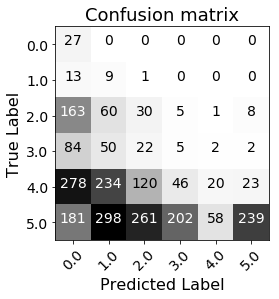

In [96]:
stats.print_big4(res_e1_1['y_true'], res_e1_1['y_pred'])
stats.print_stats(res_e1_1['y_true'], res_e1_1['y_pred'])
stats.plot_confusion_matrix(stats.cm(res_e1_1['y_true'], res_e1_1['y_pred']), classes=np.unique(res_e1_1['y_true']))

## E1.2 v2.0_en English Pass / Fail

In [97]:
df2_en_pf = utils.load_dataframe(language='en', version=2, pass_fail=True)
print(len(df2_en_pf))

res_e1_2 = evaluate_model(nlp_en, df2_en_pf)

2442


/home/che/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: generator 'ngrams' raised StopIteration
/home/che/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: generator 'ngrams' raised StopIteration


Accuracy: 32.146%
Precision: 91.566%
Recall: 32.146%
F1-Measure: 40.197%
Pearson's R: 0.14
Cohen's Kappa: 0.05
RMSE: 0.82
MAE: 0.68
Y-True Mean: 0.92
Y-Pred Mean: 0.25
Y-True Std Deviation: 0.27
Y-Pred Std Deviation: 0.43


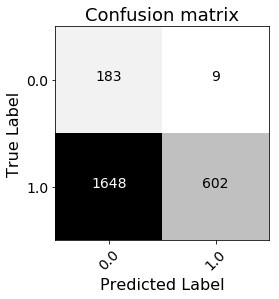

In [98]:
res_e1_2['y_pred'] = utils.convert_to_pass_fail(np.array(res_e1_2['y_pred']))

stats.print_big4(res_e1_2['y_true'], res_e1_2['y_pred'])
stats.print_stats(res_e1_2['y_true'], res_e1_2['y_pred'])
stats.plot_confusion_matrix(stats.cm(res_e1_2['y_true'], res_e1_2['y_pred']), classes=np.unique(res_e1_2['y_true']))

## E2.1 v2.0_de German Language

2442


/home/che/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: generator 'ngrams' raised StopIteration
/home/che/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: generator 'ngrams' raised StopIteration


Accuracy: 9.337%
Precision: 52.232%
Recall: 9.337%
F1-Measure: 13.650%
Pearson's R: 0.30
Cohen's Kappa: 0.03
RMSE: 3.46
MAE: 3.11
Y-True Mean: 4.15
Y-Pred Mean: 1.07
Y-True Std Deviation: 1.12
Y-Pred Std Deviation: 1.49


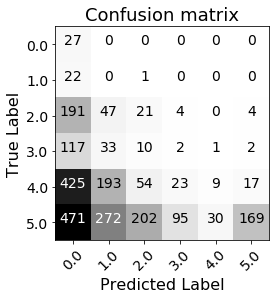

In [100]:
df2_de = utils.load_dataframe(language='de', version=2)
print(len(df2_de))
nlp_de = spacy.load('de')
res_e2_1 = evaluate_model(nlp_de, df2_de)

# Stats
stats.print_big4(res_e2_1['y_true'], res_e2_1['y_pred'])
stats.print_stats(res_e2_1['y_true'], res_e2_1['y_pred'])
stats.plot_confusion_matrix(stats.cm(res_e2_1['y_true'], res_e2_1['y_pred']), classes=np.unique(res_e2_1['y_true']))

## E2.2 v2.0_de German Language Pass/Fail

2442


/home/che/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: generator 'ngrams' raised StopIteration
/home/che/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: generator 'ngrams' raised StopIteration


Accuracy: 21.867%
Precision: 91.023%
Recall: 21.867%
F1-Measure: 25.955%
Pearson's R: 0.09
Cohen's Kappa: 0.02
RMSE: 0.88
MAE: 0.78
Y-True Mean: 0.92
Y-Pred Mean: 0.15
Y-True Std Deviation: 0.27
Y-Pred Std Deviation: 0.35


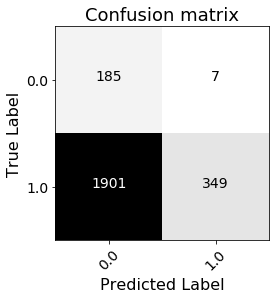

In [101]:
df2_de_pf = utils.load_dataframe(language='de', version=2, pass_fail=True)
print(len(df2_de_pf))

res_e2_2 = evaluate_model(nlp_de, df2_de_pf)

res_e2_2['y_pred'] = utils.convert_to_pass_fail(np.array(res_e2_2['y_pred']))

stats.print_big4(res_e2_2['y_true'], res_e2_2['y_pred'])
stats.print_stats(res_e2_2['y_true'], res_e2_2['y_pred'])
stats.plot_confusion_matrix(stats.cm(res_e2_2['y_true'], res_e2_2['y_pred']), classes=np.unique(res_e2_2['y_true']))

## E3.1 v2.0_es Spanish Language

2442


/home/che/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: generator 'ngrams' raised StopIteration
/home/che/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: generator 'ngrams' raised StopIteration


Accuracy: 11.671%
Precision: 49.393%
Recall: 11.671%
F1-Measure: 16.781%
Pearson's R: 0.36
Cohen's Kappa: 0.03
RMSE: 3.09
MAE: 2.70
Y-True Mean: 4.15
Y-Pred Mean: 1.50
Y-True Std Deviation: 1.12
Y-Pred Std Deviation: 1.60


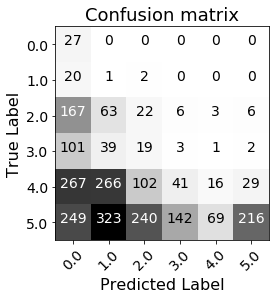

In [102]:
df2_es = utils.load_dataframe(language='es', version=2)
print(len(df2_es))
nlp_es = spacy.load('es')
res_e3_1 = evaluate_model(nlp_es, df2_es)

# Stats
stats.print_big4(res_e3_1['y_true'], res_e3_1['y_pred'])
stats.print_stats(res_e3_1['y_true'], res_e3_1['y_pred'])
stats.plot_confusion_matrix(stats.cm(res_e3_1['y_true'], res_e3_1['y_pred']), classes=np.unique(res_e3_1['y_true']))

## E3.2 v2.0_es Spanish Language Pass/Fail

2442


/home/che/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: generator 'ngrams' raised StopIteration
/home/che/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: generator 'ngrams' raised StopIteration


Accuracy: 28.829%
Precision: 90.985%
Recall: 28.829%
F1-Measure: 35.973%
Pearson's R: 0.11
Cohen's Kappa: 0.03
RMSE: 0.84
MAE: 0.71
Y-True Mean: 0.92
Y-Pred Mean: 0.22
Y-True Std Deviation: 0.27
Y-Pred Std Deviation: 0.41


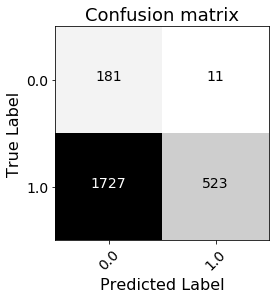

In [103]:
df2_es_pf = utils.load_dataframe(language='es', version=2, pass_fail=True)
print(len(df2_es_pf))

res_e3_2 = evaluate_model(nlp_es, df2_es_pf)

res_e3_2['y_pred'] = utils.convert_to_pass_fail(np.array(res_e3_2['y_pred']))

stats.print_big4(res_e3_2['y_true'], res_e3_2['y_pred'])
stats.print_stats(res_e3_2['y_true'], res_e3_2['y_pred'])
stats.plot_confusion_matrix(stats.cm(res_e3_2['y_true'], res_e3_2['y_pred']), classes=np.unique(res_e3_2['y_true']))